# Payload Shift

How robust are these models to payload weight changes mid-flight?

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

from environments import OctorotorEnvSelector
from systems.pid_agent import PIDAgent
from multirotor.helpers import DataLog

In [2]:
def get_tte(initial_pos: tuple, waypoints: np.ndarray, x: np.ndarray, y:np.ndarray, z:np.ndarray) -> np.ndarray:
        """
        Calculates the trajectory tracking error. 
        The distance between the current point and the vector between previous and next wp. Uses ||v1 x v2|| / ||v1||.

        Parameters
        ----------
        initial_pos : tuple  
            the initial position of the UAV.
        waypoints : np.ndarray 
            the reference positions at each point in time.
        x : np.ndarray 
            the x positions of the UAV.
        y : np.ndarray 
            the y positions of the UAV.
        z : np.ndarray
            the z positions of the UAV.

        Returns
        -------
        np.ndarray 
            the trajectory tracking error at each point in time.
        """
        ttes = []
        prev = initial_pos
        for i, waypoint in enumerate(waypoints):
            if i > 0 and not np.array_equal(waypoints[i-1], waypoints[i]):
                prev = waypoints[i-1]

            v1 = waypoint - prev
            v2 = np.array([x[i],y[i],z[i]]) - prev
            tte = np.linalg.norm(np.cross(v1, v2)) / (np.linalg.norm(v1) + 1e-6)
            ttes.append(tte)
                
        return np.array(ttes)

def toc(tte: np.ndarray):
    corridor = 2
    return len(tte[tte > corridor]) / 2

def completed_mission(waypoints: np.ndarray, x: np.ndarray, y: np.ndarray, z: np.ndarray, radius: float = 0.65):
        for waypoint in waypoints:
            reached_waypoint = False

            for position in zip(x,y,z):
                dist = np.linalg.norm(waypoint - position)

                if dist <= radius:
                    reached_waypoint = True
                    break

            if not reached_waypoint:
                return False
            
        return True

In [3]:
env_selector = OctorotorEnvSelector()
pid_sl_params = {'steps_u':50, 'scaling_factor':0, 'window_distance':10}
pid_sl_agent = PIDAgent()

pid_params = {'steps_u':50, 'scaling_factor':0, 'window_distance':1000}
pid_agent = PIDAgent()

study, naive_agent, naive_params = get_agent('naive')
naive_params['steps_u'] = 50
naive_params['bounding_rect_length']=1000

study, oracle_agent, oracle_params = get_agent('oracle')
oracle_params['steps_u'] = 50
oracle_params['bounding_rect_length']=1000

study, lstm_agent, lstm_params = get_agent('windlstm')
lstm_params['steps_u'] = 50
lstm_params['bounding_rect_length']=1000

[I 2023-09-29 01:12:49,969] Using an existing study with name 'naive' instead of creating a new one.
[I 2023-09-29 01:12:51,508] Using an existing study with name 'oracle' instead of creating a new one.
[I 2023-09-29 01:12:51,552] Using an existing study with name 'windlstm' instead of creating a new one.


In [4]:
all_agents = [pid_agent, pid_sl_agent, naive_agent, oracle_agent, lstm_agent]
all_params = [pid_params, pid_sl_params, naive_params, oracle_params, lstm_params]
names = ['PID', 'PID SL', 'Naive Agent', 'Oracle Agent', 'LSTM Agent']
env_types = ['sliding', 'sliding', 'naive', 'oracle', 'lstm']

In [5]:
nasa_wp = np.asarray([ # defines a real trajectory shown in a NASA paper
    [164.0146725649829, -0.019177722744643688, 30],
    [165.6418055187678, 111.5351051245816, 30],
    [127.3337449710234, 165.73576059611514, 30],
    [-187.28170707810204, 170.33217775914818, 40],
    [-192.03130502498243, 106.30660058604553, 40],
    [115.89920266153058, 100.8644210617058, 30],
    [114.81859536317643, 26.80923518165946, 30],
    [-21.459931490011513, 32.60508110653609, 30]
])

In [6]:
def sample_wind_range(magnitude):
    random_angle_degrees = np.random.uniform(0, 360)

    # Step 2: Convert the angle to radians
    random_angle_radians = np.deg2rad(random_angle_degrees)
    
    # Step 3: Calculate the components of the unit vector
    x_component = np.cos(random_angle_radians)
    y_component = np.sin(random_angle_radians)
    
    # Step 4: Create the unit vector
    unit_vector = np.array([x_component, y_component]) 
    wind_vector = unit_vector * magnitude

    wind_range = [(wind_vector[0], wind_vector[0]), (wind_vector[1], wind_vector[1]), (0,0)]
    return wind_range, wind_vector

In [7]:
def run_trajectory(env_selector, agent, params, current_mass, env_type, new_uav=False):
    wind_ranges, wind_vector = sample_wind_range(np.random.uniform(0,10))
    env = env_selector.get_env(env_type, params, wind_ranges, nasa_wp, start_alt=30, has_turbulence=True)

    done = False
    state = np.array(env.reset(), dtype=np.float32)
    log = DataLog(env.base_env.vehicle, env.base_env.ctrl,
                      other_vars=('reward',))

    seconds = 0
    while not done:
        action = agent.predict(state, deterministic=True)[0]
        state, reward, done, info = env.step(action)
        state = np.array(state, dtype=np.float32)
        log.log(reward=reward)
        seconds += 0.5

        if seconds == 20:
            env.base_env.vehicle.params.mass = current_mass

    log.done_logging()
    return log, info

In [8]:
def run_masses(env_selector, agents, params, masses, n_rep, types, names):
    results = pd.DataFrame(columns=['Agent', 'Mass', 'Total TTE', 'Mean TTE', 'Completed Mission', 'Reward', 'Time Outside Corridor'])
    for i in tqdm(range(n_rep)):
        for mass in masses:
            for agent, name, param, env_type in zip(agents, names, params, types):
                log, info = run_trajectory(env_selector, agent, param, mass, env_type)
                traj_err = get_tte(np.array([0,0,0]), log.target.position, log.x, log.y, log.z)
                new_result = {
                    'Agent': name,
                    'Mass': mass,
                    'Mean TTE': np.mean(traj_err),
                    'Total TTE': np.sum(traj_err),
                    'Completed Mission': completed_mission(nasa_wp, log.x, log.y, log.z, radius=5),
                    'Reward': np.sum(log.reward),
                    'Time Outside Corridor': toc(traj_err)
                }
                results = pd.concat([results, pd.DataFrame([new_result])], ignore_index=True)

    return results

In [25]:
masses = [8, 12]
n_rep = 5
results = run_masses(env_selector, all_agents, all_params, masses, n_rep, env_types, names)

  0%|                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]/home/courseac/miniconda3/envs/supervisor-control/lib/python3.9/site-packages/torch/nn/modules/rnn.py:769: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [18:52<00:00, 226.59s/it]


In [26]:
results.to_csv('./data/payload_shift.csv')

In [27]:
results

,Agent,Changes,Total TTE,Mean TTE,Completed Mission,Reward,Time Outside Corridor,Mass
0,PID,NaN,2092.016748,9.730310,True,3941.417236,69.0,8.0
1,PID SL,NaN,2453.802114,3.456059,True,-4333.032227,5.5,8.0
2,Naive Agent,NaN,868.424652,1.481953,True,11400.787109,0.5,8.0
3,Oracle Agent,NaN,537.229838,0.909018,True,14627.111328,0.5,8.0
4,LSTM Agent,NaN,503.325988,0.958716,True,14999.362305,0.5,8.0
5,PID,NaN,3523.144147,14.498536,True,-11348.631836,78.5,12.0
6,PID SL,NaN,1002.757182,1.322899,True,10071.567383,4.5,12.0
7,Naive Agent,NaN,1163.727445,1.923516,True,8503.278320,19.5,12.0
8,Oracle Agent,NaN,557.172693,0.942763,True,14421.203125,0.5,12.0
9,LSTM Agent,NaN,1041.203302,1.971976,True,9655.013672,0.5,12.0


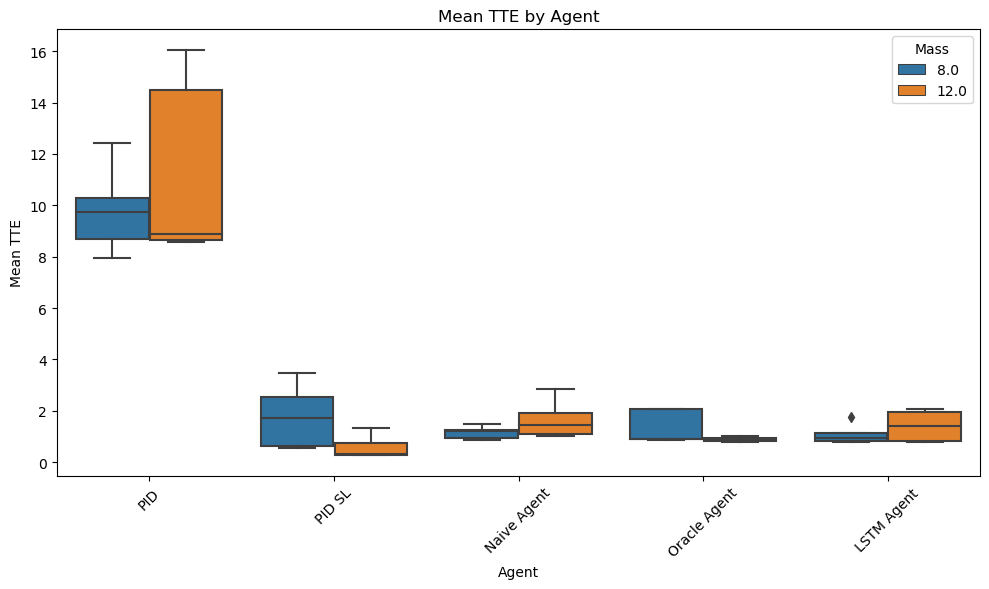

In [36]:
import seaborn as sns

plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
sns.boxplot(x='Agent', y='Mean TTE', data=results, hue='Mass')
plt.title('Mean TTE by Agent')
plt.ylabel('Mean TTE')
plt.xlabel('Agent')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

plt.tight_layout()  # Ensure labels are not cut off
plt.show()

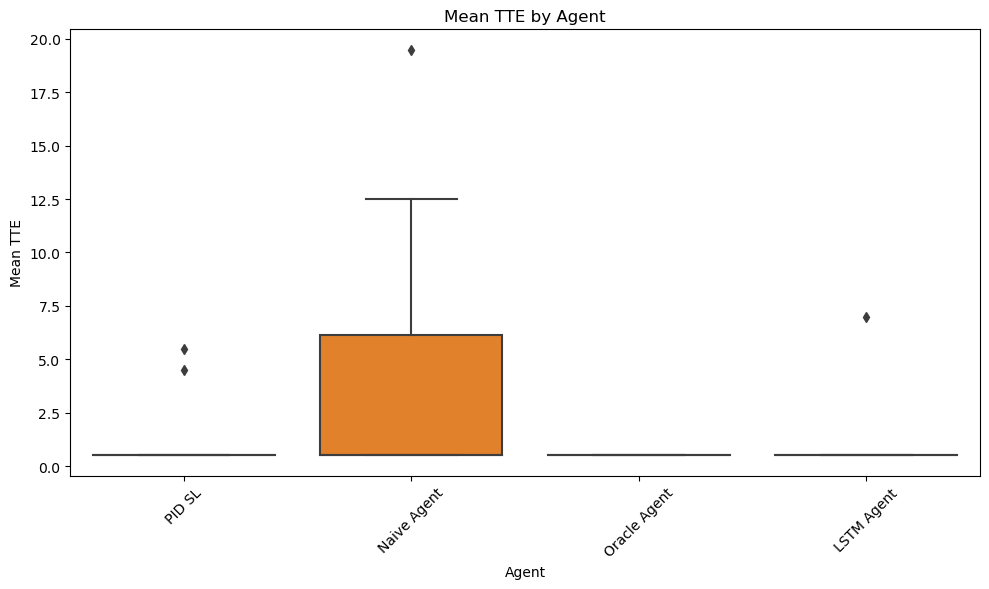

In [34]:
import seaborn as sns

plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
sns.boxplot(x='Agent', y='Time Outside Corridor', data=results[results['Agent'] != 'PID'])
plt.title('Mean TTE by Agent')
plt.ylabel('Mean TTE')
plt.xlabel('Agent')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

plt.tight_layout()  # Ensure labels are not cut off
plt.show()

Sweep over a bunch of masses with our proposed agent

In [32]:
masses = [8, 10, 12, 14, 16]
n_rep = 25
results_masses = run_masses(env_selector, [lstm_agent], [lstm_params], masses, n_rep, ['lstm'], ['LSTM Agent'])

  0%|                                                                                    | 0/25 [00:00<?, ?it/s]/home/courseac/miniconda3/envs/supervisor-control/lib/python3.9/site-packages/torch/nn/modules/rnn.py:769: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
100%|███████████████████████████████████████████████████████████████████████████| 25/25 [39:12<00:00, 94.10s/it]


In [33]:
results_masses.to_csv('./data/lstm_mass_sweep_25.csv')

In [34]:
results_masses = pd.read_csv('./data/lstm_mass_sweep_25.csv')

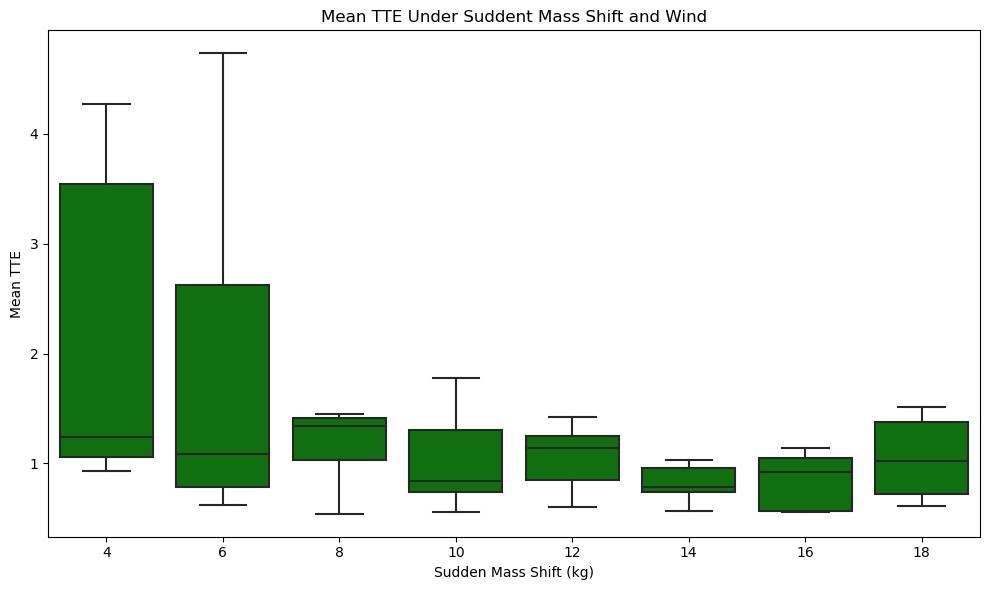

In [16]:
import seaborn as sns

# combine this with the one for the other UAV type too
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
sns.boxplot(x='Mass', y='Mean TTE', color='green', data=results_masses, showfliers=False)
plt.title('Mean TTE Under Suddent Mass Shift and Wind')
plt.ylabel('Mean TTE')
plt.xlabel('Sudden Mass Shift (kg)')

plt.tight_layout()  # Ensure labels are not cut off
plt.show()

In [35]:
masses = [8, 10, 12, 14, 16]
n_rep = 25
results_masses_new = run_masses(env_selector, [lstm_agent], [lstm_params], masses, n_rep, ['dji_lstm'], ['LSTM Agent'])

  0%|                                                                                    | 0/25 [00:00<?, ?it/s]/home/courseac/miniconda3/envs/supervisor-control/lib/python3.9/site-packages/torch/nn/modules/rnn.py:769: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
100%|███████████████████████████████████████████████████████████████████████████| 25/25 [39:18<00:00, 94.33s/it]


In [36]:
results_masses_new.to_csv('./data/lstm_mass_sweep_new_25.csv')

In [37]:
results_masses_new = pd.read_csv('./data/lstm_mass_sweep_new_25.csv')

In [12]:
results_masses_new

,Unnamed: 0,Agent,Mass,Total TTE,Mean TTE,Completed Mission,Reward,Time Outside Corridor
0,0,LSTM Agent,8,655.242591,1.155631,True,13484.4800,0.5
1,1,LSTM Agent,10,356.053238,0.630183,True,16400.6560,0.5
2,2,LSTM Agent,12,410.311306,0.717327,True,15906.0650,0.5
3,3,LSTM Agent,14,359.060053,0.635505,True,16397.1110,0.5
4,4,LSTM Agent,16,317.872267,0.562606,True,16788.4220,0.5
5,5,LSTM Agent,18,318.186312,0.564160,True,16789.2380,0.5
6,6,LSTM Agent,8,871.391133,1.510210,True,11345.5300,0.5
7,7,LSTM Agent,10,599.494913,1.028293,True,14008.8640,0.5
8,8,LSTM Agent,12,304.684246,0.540220,True,16917.1300,0.5
9,9,LSTM Agent,14,392.080021,0.695177,True,16065.7830,0.5


In [38]:
results_masses_new['Agent'] = 'DJI'

In [39]:
results_masses['Agent'] = 'Tarot'

In [40]:
results = pd.concat([results_masses, results_masses_new])
results

,Unnamed: 0,Agent,Mass,Total TTE,Mean TTE,Completed Mission,Reward,Time Outside Corridor
0,0,Tarot,8,881.300761,1.527384,True,11219.821,0.5
1,1,Tarot,10,372.303861,0.663643,True,16251.688,0.5
2,2,Tarot,12,582.665732,1.029445,True,14201.846,0.5
3,3,Tarot,14,312.239294,0.554599,True,16845.785,0.5
4,4,Tarot,16,379.475500,0.672829,True,16177.957,0.5
...,...,...,...,...,...,...,...,...
120,120,DJI,8,696.057928,1.227615,True,13071.661,0.5
121,121,DJI,10,360.132248,0.639667,True,16374.154,0.5
122,122,DJI,12,579.894438,1.026362,True,14224.818,0.5
123,123,DJI,14,323.208815,0.573065,True,16750.710,0.5


In [27]:
filtered_results[filtered_results['Mass'] == 8]

,Unnamed: 0,Agent,Mass,Total TTE,Mean TTE,Completed Mission,Reward,Time Outside Corridor
2,2,Tarot,8,477.466777,0.834732,True,1.524464e+04,0.5
10,10,Tarot,8,539.013978,0.940688,True,1.465940e+04,0.5
18,18,Tarot,8,811.963742,1.402355,True,1.191781e+04,0.5
26,26,Tarot,8,836.400183,1.452084,True,1.167962e+04,0.5
34,34,Tarot,8,762.889041,1.304084,True,1.240865e+04,0.5
42,42,Tarot,8,822.130772,1.417467,True,1.184487e+04,0.5
50,50,Tarot,8,122447.960504,336.395496,False,-1.219060e+06,149.0
58,58,Tarot,8,305.364886,0.542389,True,1.691702e+04,0.5
66,66,Tarot,8,789.042449,1.360418,True,1.216044e+04,0.5
74,74,Tarot,8,774.951987,1.313478,True,1.231173e+04,0.5


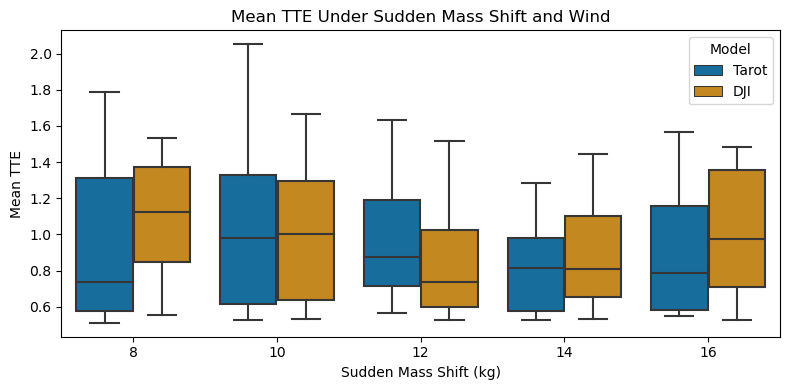

In [42]:
import seaborn as sns

mass_values_to_include = [8, 10, 12, 14, 16]  

# Filter the data frame to include only the specified Mass values - ones that are realistic for the vehicle to experience
filtered_results = results[results['Mass'].isin(mass_values_to_include)]
# filtered_results = filtered_results.drop(50)

# combine this with the one for the other UAV type too
plt.figure(figsize=(8, 4))  # Adjust the figure size if needed
ax = sns.boxplot(x='Mass', y='Mean TTE', hue='Agent', data=filtered_results, showfliers=False, palette="colorblind")
plt.title('Mean TTE Under Sudden Mass Shift and Wind')
plt.ylabel('Mean TTE')
plt.xlabel('Sudden Mass Shift (kg)')
ax.legend(title='Model')

plt.tight_layout()  # Ensure labels are not cut off
plt.show()